# セットアップ

In [1]:
# 使用モジュールをインポート
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# データの前処理

## データの取得

In [2]:
# ファイルを取得して、パスを通す
file = "directory_to_extract"
dirty_dir = os.path.join(file, "firty")
clear_dir = os.path.join(file, "clear")

**directory_to_extract**

|__ **dirty**: [img00001.jpg, img00002.jpg, img00003.jpg ...]

|__ **clear**: [img24001.jpg, img24002.jpg, img24003 ...]

In [3]:
# バッチサイズ、画像サイズの決定
BATCH_SIZE = 64
IMG_SIZE = (160, 160)

In [4]:
os.getcwd()

'/home/acc12766rp/database'

In [5]:
os.chdir("/home/acc12766rp/database")

In [6]:
# データセットの作成
train_dataset = image_dataset_from_directory(file, shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 2920 files belonging to 2 classes.


In [7]:
# クラス名を与える
class_names = train_dataset.class_names

## データを分割する

In [8]:
# train_datasetからテスト・検証用データを作る

# trainのバッチサイズを取得
train_batches = tf.data.experimental.cardinality(train_dataset)

# trainの半分のバッチををvalidationに移す
validation_dataset = train_dataset.take(train_batches // 2)
train_batches = train_dataset.skip(train_batches // 2)

# validation_datasetの20％のバッチをtestに移す
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
val_batches = validation_dataset.skip(val_batches // 5)

In [10]:
it = iter(train_dataset)

In [11]:
next(it)

(<tf.Tensor: shape=(64, 160, 160, 3), dtype=float32, numpy=
 array([[[[212.22     , 216.22     , 193.22     ],
          [215.3      , 223.3      , 199.3      ],
          [211.8      , 220.85     , 194.       ],
          ...,
          [211.05     , 199.95     , 160.35     ],
          [206.19995  , 201.69998  , 169.34     ],
          [189.63998  , 202.22993  , 131.26004  ]],
 
         [[215.2      , 219.2      , 196.2      ],
          [212.9      , 220.9      , 196.9      ],
          [210.5      , 220.65     , 195.6      ],
          ...,
          [215.9      , 199.1      , 170.       ],
          [210.09995  , 200.       , 172.89998  ],
          [194.46997  , 199.36993  , 148.22998  ]],
 
         [[216.8      , 221.65     , 198.65     ],
          [213.8      , 222.8      , 198.3      ],
          [208.75     , 221.       , 195.25     ],
          ...,
          [214.       , 206.5      , 171.75     ],
          [200.74994  , 201.14996  , 162.14996  ],
          [186.44998  

In [9]:
# データの送受信を効率化
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# モデル構築

In [10]:
# データ拡張層
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [11]:
# MobileNetV2に入力できるよう変形する層
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [12]:
# 画像サイズの指定
IMG_SHAPE = IMG_SIZE + (3,)

# ベースモデル作成
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [13]:
# バッチサイズの取得
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 5, 5, 1280)


In [14]:
# ベースモデルの学習を無効化
base_model.trainable = False

In [15]:
# ベースモデルのアーキテクチャ確認
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [16]:
# pooling層
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 1280)


In [17]:
# 2値分類を行う全結合層
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 1)


In [18]:
# 層をチェーン化してモデルを作る
inputs = tf.keras.Input(shape=(160, 160, 3))  # 入力
x = data_augmentation(inputs) # データ拡張
x = preprocess_input(x) # データの前処理
x = base_model(x, training=False) #ベースモデル
x = global_average_layer(x) # プーリング層
x = tf.keras.layers.Dropout(0.2)(x) # ドロップアウト
outputs = prediction_layer(x) # 全結合層、出力
model = tf.keras.Model(inputs, outputs) # モデル

In [19]:
# モデルコンパイル
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

/home/acc12766rp/database/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [20]:
# モデル訓練
initial_epochs = 10

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
46/46 [==============================] - 20s 391ms/step - loss: 0.7419 - accuracy: 0.5579 - val_loss: 0.6067 - val_accuracy: 0.6270
Epoch 2/10
46/46 [==============================] - 17s 367ms/step - loss: 0.6213 - accuracy: 0.6493 - val_loss: 0.5363 - val_accuracy: 0.6739
Epoch 3/10
46/46 [==============================] - 16s 343ms/step - loss: 0.5468 - accuracy: 0.7038 - val_loss: 0.4934 - val_accuracy: 0.6950
Epoch 4/10
46/46 [==============================] - 16s 341ms/step - loss: 0.4991 - accuracy: 0.7435 - val_loss: 0.4645 - val_accuracy: 0.7323
Epoch 5/10
46/46 [==============================] - 17s 355ms/step - loss: 0.4710 - accuracy: 0.7688 - val_loss: 0.4523 - val_accuracy: 0.7378
Epoch 6/10
46/46 [==============================] - 17s 353ms/step - loss: 0.4516 - accuracy: 0.7836 - val_loss: 0.4306 - val_accuracy: 0.7629
Epoch 7/10
46/46 [==============================] - 16s 349ms/step - loss: 0.4367 - accuracy: 0.7928 - val_loss: 0.4355 - val_accuracy: 0.7534

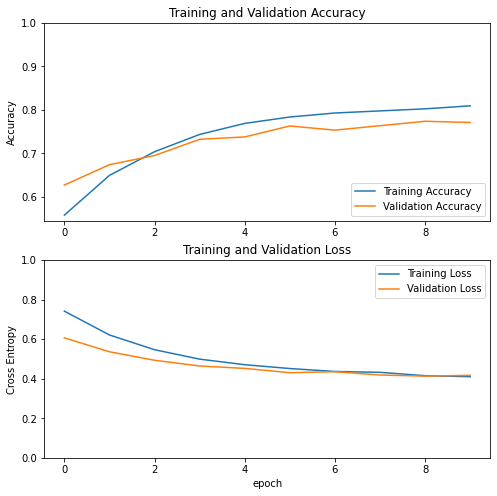

In [21]:
# 学習の様子
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# fine-tuning

In [22]:
# ベースモデルのフリーズ解除
base_model.trainable = True

In [23]:
# ベースモデルにある層の数を確認
print("Number of layers in the base model: ", len(base_model.layers))

# ファインチューニングする層の数を決める（100層）
fine_tune_at = 100

# 100層以外の層はフリーズ
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [24]:
# モデルコンパイル
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [25]:
# モデルアーキテクチャ確認
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [26]:
# モデル訓練（fine-tuning）
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
46/46 [==============================] - 26s 492ms/step - loss: 0.3905 - accuracy: 0.8233 - val_loss: 0.3396 - val_accuracy: 0.8342
Epoch 11/20
46/46 [==============================] - 22s 482ms/step - loss: 0.3600 - accuracy: 0.8397 - val_loss: 0.3503 - val_accuracy: 0.8641
Epoch 12/20
46/46 [==============================] - 22s 478ms/step - loss: 0.3407 - accuracy: 0.8483 - val_loss: 0.4132 - val_accuracy: 0.7425
Epoch 13/20
46/46 [==============================] - 23s 486ms/step - loss: 0.3283 - accuracy: 0.8507 - val_loss: 0.3038 - val_accuracy: 0.8601
Epoch 14/20
46/46 [==============================] - 23s 491ms/step - loss: 0.3224 - accuracy: 0.8572 - val_loss: 0.2964 - val_accuracy: 0.8764
Epoch 15/20
46/46 [==============================] - 22s 479ms/step - loss: 0.3137 - accuracy: 0.8623 - val_loss: 0.2864 - val_accuracy: 0.8743
Epoch 16/20
46/46 [==============================] - 24s 507ms/step - loss: 0.2978 - accuracy: 0.8719 - val_loss: 0.3134 - val_accuracy:

In [27]:
# fine-tuning後のacc, val_acc, loss, val_loss
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

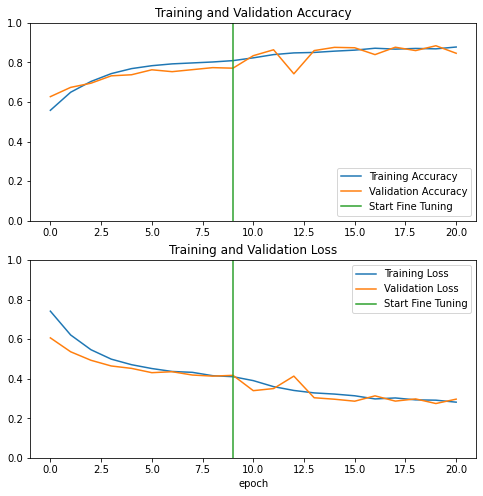

In [28]:
# 学習の様子をプロット
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# モデルの評価

In [29]:
# loss, accuracyを見てみる
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

4/4 [==============================] - 1s 213ms/step - loss: 0.3360 - accuracy: 0.8164
Test accuracy : 0.81640625


Predictions:
 [0 1 1 1 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 1 1 1 0 0 1
 0 1 1 1 1 1 0 0 1 0 1 0 1 1 1 0 0 0 0 0 1 0 0 0 1 0 1]
Labels:
 [0 0 1 1 1 0 0 1 1 0 0 0 1 1 1 0 0 0 0 1 1 0 0 1 0 0 1 1 0 1 1 1 1 1 0 0 1
 0 0 0 1 1 1 0 0 1 0 1 0 1 1 0 0 0 0 1 0 1 0 0 0 1 0 1]


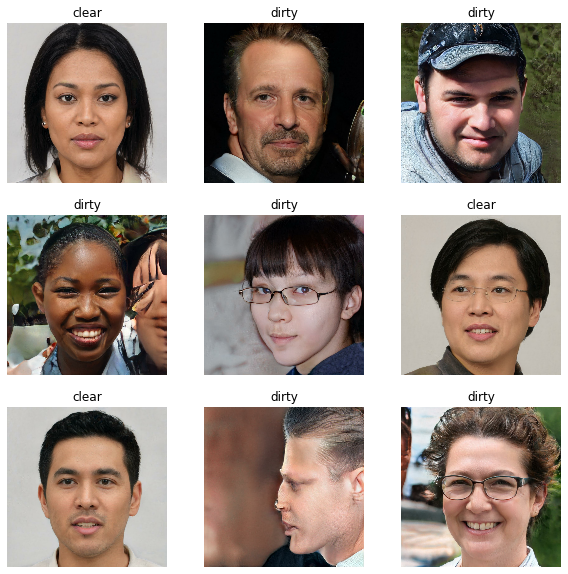

In [30]:
# バッチサイズの取得
image_batch, label_batch = test_dataset.as_numpy_iterator().next()

# モデルによる予測
predictions = model.predict_on_batch(image_batch).flatten()

# ロジット関数をシグモイドに変換
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

# 学習済みモデルの保存

In [31]:
# 保存先のパスを指定する
export_path = "weight_clear"

# モデルの保存
model.save(export_path, save_format='tf')

# 保存先を参照する
export_path

INFO:tensorflow:Assets written to: weight_clear/assets


/home/acc12766rp/database/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


'weight_clear'

In [34]:
# 保存したモデルを呼び出す
reloaded = tf.keras.models.load_model("weight_clear")

In [35]:
from PIL import Image
from tensorflow.keras import layers

IMG_SIZE = 160

resize = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE)
])

for i in range(500):
    img = Image.open("face_dataset/{number:06d}.jpg".format(number = i+1))
    img = np.array(img)
    img = img[np.newaxis, :, :, :]
    if i == 0:
        img2 = img
    else:
        img2 = np.append(img2, img, axis=0)
        
img2.shape

img3 = tf.Variable(img2)

result = resize(img3)

Predictions:
 [1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 0 0 1 1 1 0 0 1 0 1 1 1 0 1 0 0 1 0 1
 1 0 0 0 0 1 0 1 1 0 0 0 0 1 1 1 0 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 0
 1 1 1 1 1 0 0 0 1 0 0 1 1 1 1 0 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1
 1 0 1 1 1 0 0 0 1 1 1 0 0 1 1 1 1 1 1 0 0 0 1 0 1 1 1 1 1 1 0 1 1 1 0 0 0
 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 0
 1 1 1 1 1 1 1 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 1 0 0 1 0 0 1 1 1 1 1 0 0 0
 0 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1
 0 1 1 0 1 1 1 0 1 1 0 1 1 0 1 1 1 0 1 1 0 1 1 0 0 0 1 0 0 1 0 1 1 1 1 1 1
 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 0 0 1 1 1 1 1 1 0
 0 1 1 1 0 1 1 1 0 1 1 1 1 1 0 0 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 0 1
 1 0 1 1 1 0 1 0 1 1 0 1 1 0 1 0 1 0 0 1 1 1 1 1 0 1 0 0 1 1 0 0 1 1 1 1 1
 1 1 0 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 1 1 1 1 1 0 0 1 1 1 0 1 0
 1 0 1 0 0 

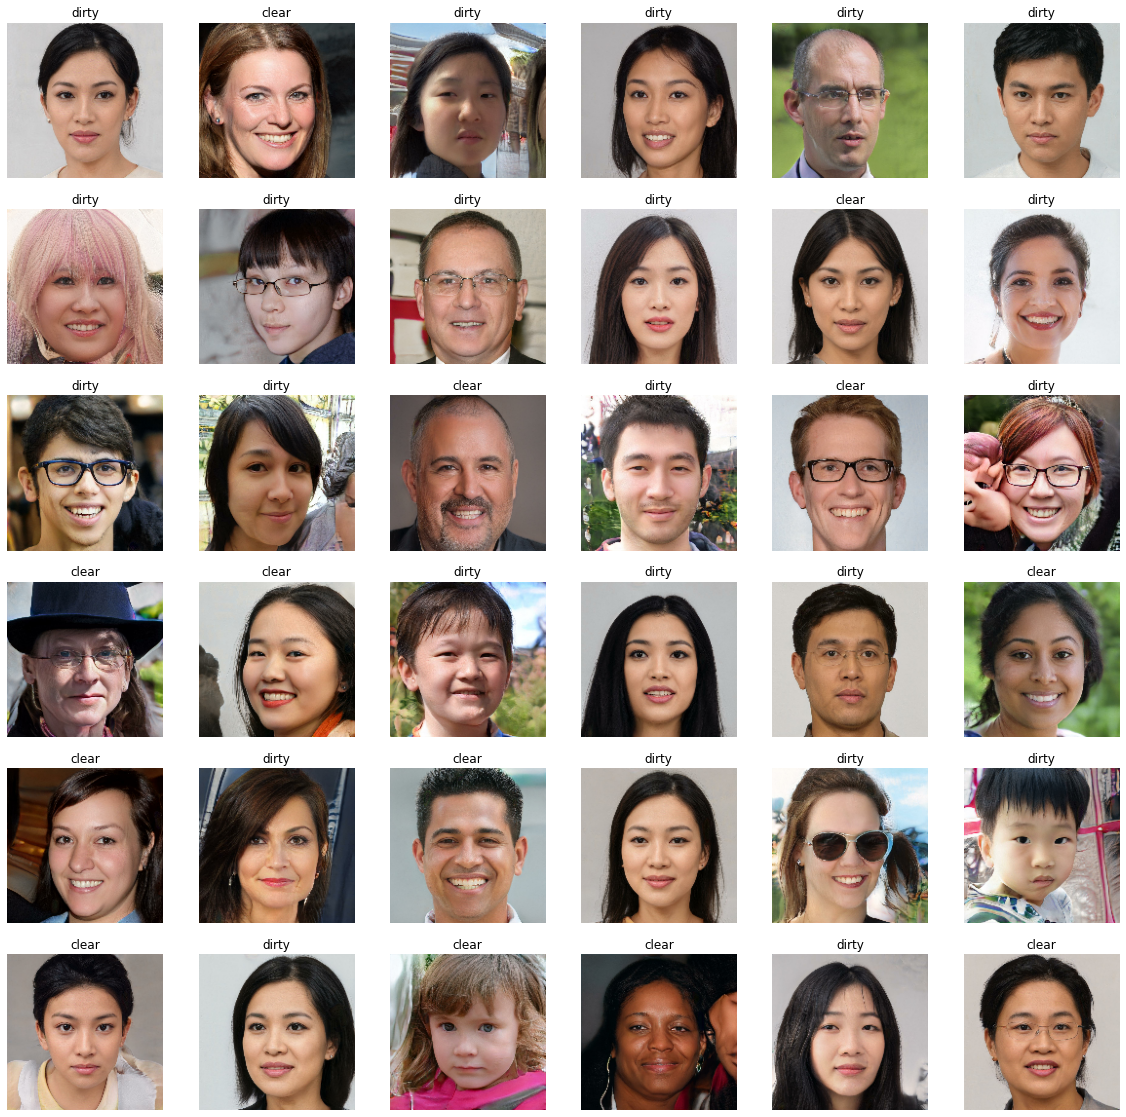

In [36]:
# バッチサイズの取得
image_batch, label_batch = test_dataset.as_numpy_iterator().next()

# モデルによる予測
predictions = reloaded.predict_on_batch(result).flatten()

# ロジット関数をシグモイドに変換
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(20, 20))
for i in range(36):
  ax = plt.subplot(6, 6, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")